**Import all the libraries :**

In [ ]:
import os
import re
import cv2
import time
import tarfile
import datetime
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow import concat
from tensorflow import repeat
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from skimage.transform import resize
import nltk.translate.bleu_score as bleu
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import expand_dims 
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import concatenate, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Layer, Dropout, GRU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load structured data :**

In [ ]:
train = np.load('/content/drive/MyDrive/train.npy',allow_pickle=True)
test = np.load('/content/drive/MyDrive/test.npy',allow_pickle=True)
validation = np.load('/content/drive/MyDrive/validation.npy',allow_pickle=True)

columns = ["front X-Ray", "lateral X-Ray", "findings", "dec_ip", "dec_op", "image_features"]

train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns)
validation = pd.DataFrame(validation, columns = columns)

#Reshaping the Image tensors for training
train_image_features = np.vstack(train.image_features).astype(np.float)
validation_image_features = np.vstack(validation.image_features).astype(np.float)

**Load Image Data :**

In [ ]:
cwd = os.getcwd()
images = tarfile.open('/content/drive/MyDrive/NLMCXR_png.tgz')
images.extractall(cwd+'/images/')

**Loading CheXNet Model :**

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CheXNet')

**Text Tokenization :**

In [ ]:
token = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n')
token.fit_on_texts(train['findings'])

token.word_index['<pad>'] = 0
token.index_word[0] = '<pad>'
vocab_size = len(token.word_index) + 1

#sequence in train and validation
train_inp_dec = token.texts_to_sequences(train.dec_ip)
train_op_dec = token.texts_to_sequences(train.dec_op)
val_inp_dec = token.texts_to_sequences(validation.dec_ip)
val_op_dec = token.texts_to_sequences(validation.dec_op)

#padding in the train and validation 
max_len = 100
decoder_input = pad_sequences(train_inp_dec, maxlen=max_len, padding='post')
decoder_output =  pad_sequences(train_op_dec, maxlen=max_len, padding='post') 
Validation_decoder_input = pad_sequences(val_inp_dec, maxlen=max_len, padding='post') 
Validation_decoder_output = pad_sequences(val_op_dec, maxlen=max_len, padding='post')

word_idx = {}
idx_word = {}
for key, value in (token.word_index).items(): 
    word_idx[key] = value
    idx_word[value] = key

In [ ]:
batch_size     = 50
Buffer_size    = 500

train_dataset = tf.data.Dataset.from_tensor_slices(((train_image_features, decoder_input), decoder_output))
train_dataset = train_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_image_features,Validation_decoder_input),Validation_decoder_output))
validation_dataset = validation_dataset.shuffle(Buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Loading Model Architacture :**

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self,lstm_units):
        super().__init__()
        
        self.lstm_units = lstm_units
        self.dense      = Dense(self.lstm_units, kernel_initializer="glorot_uniform", name = 'encoder_dense_layer')
        
    def initialize_states(self,batch_size):
      
        self.batch_size  = batch_size
        self.enc_h       = tf.zeros((self.batch_size, self.lstm_units))
      
        return self.enc_h
    
    def call(self,x):
      
        # x : image_data
        encoder_output = self.dense(x)
      
        return encoder_output  


class Attention(tf.keras.layers.Layer):
    '''
    Class that calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,attention_units):
        super().__init__()

        self.attention_units = attention_units  

        self.w1_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w1_Dense')
        self.w2_Dense    =  tf.keras.layers.Dense(self.attention_units, kernel_initializer="glorot_uniform", name='Concat_w2_Dense')
        self.Concat_Dense=  tf.keras.layers.Dense(1, kernel_initializer="glorot_uniform", name = 'Concat_Dense_layer')
  
    def call(self,x):
    
        self.decoder_hidden_state, self.encoder_output = x
        self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    
        score = self.Concat_Dense(tf.nn.tanh(self.w1_Dense(self.decoder_hidden_state) + self.w2_Dense(self.encoder_output)))
    
        att_weights    = tf.nn.softmax(score, axis=1)
        context_vector = att_weights * self.encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)   
    
        return context_vector,att_weights


class OneStepDecoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
        super().__init__()
      
        self.lstm_units     = lstm_units
        self.vocab_size     = vocab_size
        self.embedding_dim  = embedding_dim
        self.attention_units= attention_units
      
        self.dense       = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name ='onestep_dense')
        self.attention   = Attention( self.attention_units)
        self.decoder_emb = Embedding(self.vocab_size, self.embedding_dim, trainable = True , name = 'Decoder_embedding')           
        self.decoder_gru = GRU(self.lstm_units, return_state=True, return_sequences=True, name="Decoder_LSTM") 
      
      
        self.dropout1 = Dropout(0.3,name = 'dropout1')
        self.dropout2 = Dropout(0.3,name = 'dropout2')
        self.dropout3 = Dropout(0.3,name = 'dropout3')
  
    @tf.function
    def call(self,x,training=None):
    
        self.input_to_decoder, self.encoder_output, self.state_h = x

        embedded_output = self.decoder_emb(self.input_to_decoder)
        embedded_output = self.dropout1(embedded_output)
    
        y = [self.state_h,self.encoder_output]
        context_vector, att_weights = self.attention(y)

        concated_decoder_input = tf.concat([tf.expand_dims(context_vector, 1),embedded_output], -1)
        concated_decoder_input = self.dropout2(concated_decoder_input)

        output_gru, hidden_state = self.decoder_gru(concated_decoder_input, initial_state=self.state_h)
    
        output_gru = tf.reshape(output_gru, (-1, output_gru.shape[2]))
        output_gru = self.dropout3(output_gru)

        output = self.dense(output_gru)

        return output,hidden_state,att_weights,context_vector


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units):
        super().__init__()

        self.lstm_units     = lstm_units
        self.vocab_size     = vocab_size
        self.embedding_dim  = embedding_dim
        self.attention_units= attention_units
      
        self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.lstm_units, self.attention_units)

    @tf.function
    def call(self, x,training=None):
        
        self.input_to_decoder, self.encoder_output, self.decoder_hidden_state = x
        all_outputs = tf.TensorArray(tf.float32,size = self.input_to_decoder.shape[1], name = 'output_arrays' )
        
        for timestep in tf.range(self.input_to_decoder.shape[1]):
          
            y = [self.input_to_decoder[:,timestep:timestep+1],self.encoder_output, self.decoder_hidden_state]
            output,hidden_state,att_weights,context_vector = self.onestepdecoder(y)
          
            self.decoder_hidden_state = hidden_state
            all_outputs = all_outputs.write(timestep,output)
        
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs


class Encoder_decoder(tf.keras.Model):
    """
     # Intialize encoder states, Pass the encoder_sequence to the embedding layer
     # Decoder initial states are encoder final states, Initialize it accordingly
     # Pass the decoder sequence,encoder_output,decoder states to Decoder
     # return the decoder output
  
    """ 
    def __init__(self, vocab_size, embedding_dim, lstm_units, attention_units, batch_size):
        super().__init__()

        self.vocab_size     = vocab_size
        self.batch_size     = batch_size
        self.lstm_units     = lstm_units
        self.embedding_dim  = embedding_dim
        self.attention_units= attention_units
        
        self.encoder = Encoder(self.lstm_units)
        self.decoder = Decoder(vocab_size, embedding_dim, lstm_units, attention_units)
        self.dense   = Dense(self.vocab_size, kernel_initializer="glorot_uniform", name = 'enc_dec_dense')

  
    def call(self,data):
    
        self.inputs, self.outputs = data[0], data[1]

        self.encoder_hidden = self.encoder.initialize_states(self.batch_size)
        self.encoder_output = self.encoder(self.inputs)
    
        x = [self.outputs,self.encoder_output,self.encoder_hidden]
        output = self.decoder(x)
    
        return output


**Custom loss function :**

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Load Model :**

In [ ]:
lstm_units     = 256
embedding_dim  = 300
attention_units= 64
tf.keras.backend.clear_session()
Attention_model = Encoder_decoder(vocab_size,embedding_dim,lstm_units,attention_units,batch_size)
Attention_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=loss_function)
Attention_model.fit(train_dataset, validation_data=validation_dataset, epochs=1, shuffle=True)

64/64 [==============================] - 52s 728ms/step - loss: 1.4441 - val_loss: 1.3424


**Loading best pre-trained weights :**

In [ ]:
Attention_model.load_weights('/content/Attention_model.h5')

**Prediction : Beam Search AND Inference : Model Evaluation & Image Plotting**

In [ ]:
def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (256,256,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)
    
  return X

def preprocess(image1_paths,image2_paths):

  '''
    input -- dataframe(df)
    output -- dataframe(df)
    process - convert images into 256 X 256, then using CHeXNET model generate tensor(concate two image tensor)
  
  '''
  path = '/content/images/'

  image_features = []
  for i in range(len(image1_paths)):

    i1 = load_image(path+image1_paths)
    i2 = load_image(path+image2_paths)
    img1_features = model.predict(i1)
    img2_features = model.predict(i2)
    img1_features = np.vstack(img1_features).astype(np.float)
    img2_features = np.vstack(img2_features).astype(np.float)
    
    tensor = np.concatenate((img1_features, img2_features), axis=1)

  return tensor

#Refrence : https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

def evaluate(image1, image2):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function takes images and using encoder decoder model
    return medical report of the images
    The function predicts the sentence using beam search

    '''

    img_tensor     = preprocess(image1, image2)
    image_features = np.vstack(img_tensor).astype(np.float)

    result = ''
    initial_state  = Attention_model.layers[0].initialize_states(1)
    sequences      = [['<start>', initial_state, 0]]

    encoder_output       = Attention_model.layers[0](image_features)
    decoder_hidden_state = initial_state

    max_len = 75
    beam_width = 3
    finished_seq = []

    for i in range(max_len):
        new_seq = []
        all_probable = []
        
        for seq,state,score in sequences:

            cur_vec = np.reshape(word_idx[seq.split(" ")[-1]],(1,1))
            decoder_hidden_state = state
            x = [cur_vec, encoder_output, decoder_hidden_state]
            output,hidden_state,att_weights,context_vector = Attention_model.get_layer('decoder').onestepdecoder(x)
            output = tf.nn.softmax(output)
            top_words = np.argsort(output).flatten()[-beam_width:]
            for index in top_words:
         
                predicted = [seq + ' '+ idx_word[index], hidden_state, score-np.log(np.array(output).flatten()[index])]
                all_probable.append(predicted)

        sequences = sorted(all_probable, key = lambda l: l[2])[:beam_width]

        count = 0
        for seq,state,score in sequences:
            if seq.split(" ")[-1] == '<end>':
                score = score/len(seq)
                finished_seq.append([seq,state,score])
                count+=1
            else:
                new_seq.append([seq,state,score])
        
        sequences = new_seq
        beam_width= beam_width - count
        if not sequences:
            break        
        else:
            continue

    if len(finished_seq) >0:
          finished_seq = sorted(finished_seq, reverse=True, key = lambda l: l[2])
          sequences = finished_seq[-1]
          return sequences[0][8:]
    else:
          return new_seq[-1][0]

def Predict_Caption(img_data):
    
    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context
    
    '''
    path = '/content/images/'
    
    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()
    
    result = evaluate(img_data[0],img_data[1]) 
    print("Predicted Report :",result)
    print('BLEU Score :-',sentence_bleu(img_data[2], result),'\n')

**Checking predictions for single datapoint of test data :**

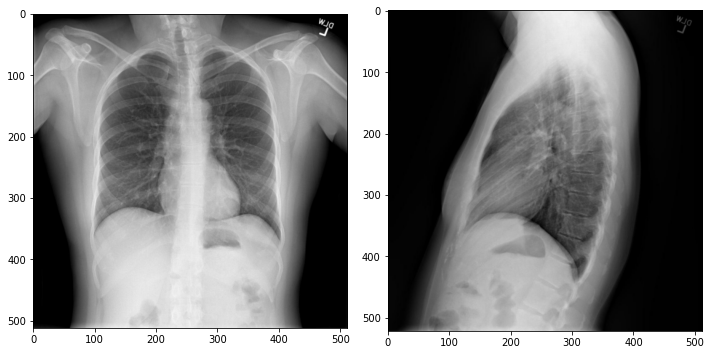

Predicted Report : the heart is normal in size and contour the lungs are clear without focal airspace opacity pleural effusion or pneumothorax the osseous structures are intact <end>
BLEU Score :- 0.6194495037003804 

CPU times: user 5.23 s, sys: 3.22 s, total: 8.45 s
Wall time: 4.96 s


In [ ]:
%%time
Predict_Caption(test.values[63])

**Note :** The Prediction time is almost 5 seconds. This latency can be reduced further if we use greedy search instead of beam search or Reduce the beam width.

**Checking  predictions for some random datapoints of test data :**

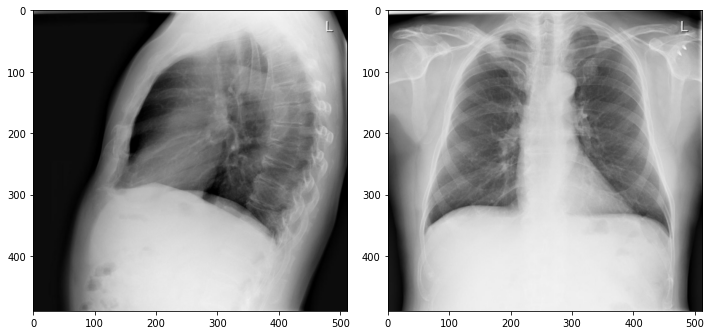

Predicted Report : the heart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits no focal consolidation suspicious pulmonary opacity large pleural effusion or pneumothorax is identified <end>
BLEU Score :- 0.577993557395349 



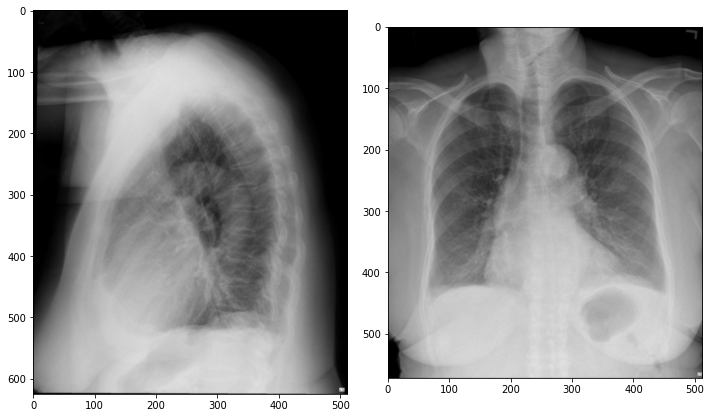

Predicted Report : the heart size and pulmonary vascularity appear within normal limits the lungs are free of focal airspace disease no pleural effusion or pneumothorax is seen <end>
BLEU Score :- 0.612893559846761 



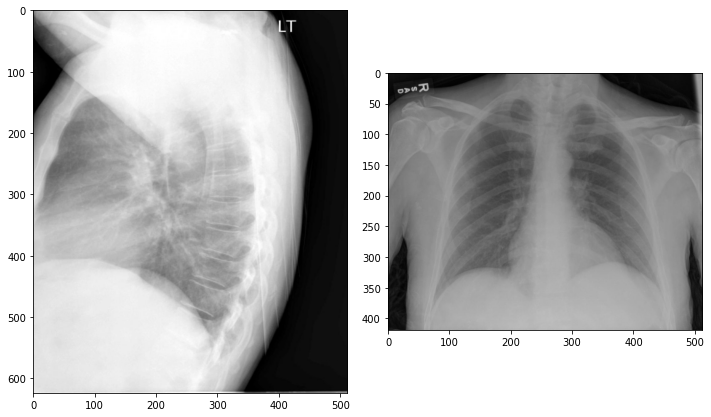

Predicted Report : the heart size and mediastinal contours appear within normal limits pulmonary vascularity is within normal limits lungs are free of focal airspace disease no pleural effusion or pneumothorax is seen degenerative changes are present in the spine <end>
BLEU Score :- 0.5446539630663 

CPU times: user 16.8 s, sys: 9.98 s, total: 26.8 s
Wall time: 16 s


In [ ]:
%%time
for i in test.values[17:20]:
    Predict_Caption(i)

**Conclusion :**

* The attention model (i.e. the best model) is predicting sentences that are grammatically correct even for long sentences.
* we need a much larger dataset which not only include images of "no disease" category but also of images that have diseases. It will improve the model performance. The final model will improve a lot if the dataset is large since some of the captions it produced were repeated.
* The Prediction time is almost 5 seconds. This latency can be reduced further if we use greedy search instead of beam search or Reduce the beam width.

